========================================================================================================

# Natural Language Processing (NLP) with LSTM. Adil Latif Habibi.

========================================================================================================

## 1. *Import semua library yang dibutuhkan diawal aagar terlihat rapi*

In [1]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.special import softmax
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## *2. Ubah dataset menjadi dataframe menggunakan pandas, lalu lakukan pengecekan data meliputi pengecekan jumlah kolom, Dtype (apakah ada yang harus dibuang)*

In [2]:
df = pd.read_csv('bbc-text.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


## *3.Pengecekan jumlah elemen*

In [3]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [4]:
df['text'].value_counts(2)

kennedy questions trust of blair lib dem leader charles kennedy has said voters now have a  fundamental lack of trust  of tony blair as prime minister.  he said backing his party was not a wasted vote  adding that with the lib dems  what you see is what you get . he made his comments at the start of a day of appearances on channel five in a session on the wright stuff programme. questions from callers  a studio audience and the show s presenter covered lib dem tax plans  anti-terror laws and immigration.  mr kennedy said during his nearly 22 years in parliament he had seen prime ministers and party leaders come and go and knew the pitfalls of british politics.  1983 was when i was first elected as an mp - so tony blair  michael howard and myself were all class of  83 - and over that nearly quarter of a century the world has changed out of recognition   he said.  we don t actually hear the argument any longer:  lib dems  good people  reasonable ideas but only if we thought they could wi

## *4. Dataframe sebelum dilakukan proses one hot encoding*

In [5]:
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


## *5. Hasil dari proses one hot encoding dan sample 5 dataframe terakhir*

In [6]:
kategori = pd.get_dummies(df.category)
df = pd.concat([df, kategori], axis=1)
df.tail(5)

,category,text,business,entertainment,politics,sport,tech
2220,business,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,politics,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,entertainment,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,politics,how political squabbles snowball it s become c...,0,0,1,0,0
2224,sport,souness delight at euro progress boss graeme s...,0,0,0,1,0


## *6. Buang kolom kategori karena sudah diganti melalui one hot encoding dan tidak diperlukan lagi*

In [7]:
ndf = df.drop(columns='category')
ndf.head(2)

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0


## *7. Cek jika ada nilai yang kosong, dan hitung banyak kata yang ada dalam kolom teks untuk membantu nanti dalam melakukan modelling*

In [8]:
ndf.isna().sum()

text             0
business         0
entertainment    0
politics         0
sport            0
tech             0
dtype: int64

In [9]:
Counter(ndf['text'])
print('banyak kata = ', len(ndf['text']))

banyak kata =  2225


## *8. Gunakan Library NLTK untuk memproses data teks. Hilangkan stopwords dan tanda baca agar data lebih siap untuk dilatih*

In [10]:
example_sent = """ A stop word is a commonly used word 
    (such as “the”, “a”, “an”, “in”) that a search engine 
    has been programmed to ignore, both when indexing entries 
    for searching and when retrieving them as the result of a 
    search query. """
  
stop_words = set(stopwords.words('english'))
  
word_tokens = word_tokenize(example_sent)
  
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  
filtered_sentence = []
  
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
  
print(word_tokens)
print(filtered_sentence)

['A', 'stop', 'word', 'is', 'a', 'commonly', 'used', 'word', '(', 'such', 'as', '“', 'the', '”', ',', '“', 'a', '”', ',', '“', 'an', '”', ',', '“', 'in', '”', ')', 'that', 'a', 'search', 'engine', 'has', 'been', 'programmed', 'to', 'ignore', ',', 'both', 'when', 'indexing', 'entries', 'for', 'searching', 'and', 'when', 'retrieving', 'them', 'as', 'the', 'result', 'of', 'a', 'search', 'query', '.']
['A', 'stop', 'word', 'commonly', 'used', 'word', '(', '“', '”', ',', '“', '”', ',', '“', '”', ',', '“', '”', ')', 'search', 'engine', 'programmed', 'ignore', ',', 'indexing', 'entries', 'searching', 'retrieving', 'result', 'search', 'query', '.']


In [11]:
sentence = "Think and wonder, wonder and think."
 
token = nltk.RegexpTokenizer(r"\w+")
new_words = token.tokenize(sentence)

## *9. Ubah nilai-nilai dari dataframe ke dalam tipe data numpy array*

In [12]:
text = ndf['text'].values
label = ndf[['business', 'entertainment', 'politics', 'sport', 'tech']].values

## *10. Bagi data untuk training dan data untuk testing*

In [30]:
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2, random_state=0)

## *11. Lakukan Proses Tokenisasi*

In [31]:
tokenizer = Tokenizer(num_words=2225, oov_token='<oov>')

tokenizer.fit_on_texts(text_train)

sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)

pad_train = pad_sequences(sekuens_train,
                          maxlen=100,
                          padding='post',
                          truncating='post')
pad_test = pad_sequences(sekuens_test,
                         maxlen=100,
                         padding='post',
                         truncating='post')

## *12. Buat arsitektur model menggunakan Sequential, layer Embedding, LSTM, Dense, dan Dropout. Kemudian panggil fungsi compile*

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2225, output_dim=32, input_length=100),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## *13. Gunakan fungsi callback untuk memberi tahu model agar berhenti melakukan pelatihan ketika sudah mencapai target tertentu. Dalam Model ini 92%*

In [40]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.92 and logs.get('val_accuracy')>=0.92):
      print("\nAkurasi training dan validasi telah mencapai nilai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

## *14.Latih model dengan menggunakan fungsi .fit()*

In [41]:
history = model.fit(pad_train, label_train, epochs=100,
                    validation_data=(pad_test, label_test), 
                    verbose=2, callbacks=[callbacks])

Epoch 1/100
56/56 - 3s - loss: 1.6052 - accuracy: 0.2292 - val_loss: 1.6015 - val_accuracy: 0.2180 - 3s/epoch - 47ms/step
Epoch 2/100
56/56 - 0s - loss: 1.4211 - accuracy: 0.3062 - val_loss: 1.1990 - val_accuracy: 0.3798 - 402ms/epoch - 7ms/step
Epoch 3/100
56/56 - 0s - loss: 0.9622 - accuracy: 0.5292 - val_loss: 0.8339 - val_accuracy: 0.5371 - 435ms/epoch - 8ms/step
Epoch 4/100
56/56 - 0s - loss: 0.6756 - accuracy: 0.6208 - val_loss: 0.7100 - val_accuracy: 0.6090 - 413ms/epoch - 7ms/step
Epoch 5/100
56/56 - 0s - loss: 0.5108 - accuracy: 0.7292 - val_loss: 0.6691 - val_accuracy: 0.7708 - 415ms/epoch - 7ms/step
Epoch 6/100
56/56 - 0s - loss: 0.4150 - accuracy: 0.8090 - val_loss: 0.5339 - val_accuracy: 0.7955 - 408ms/epoch - 7ms/step
Epoch 7/100
56/56 - 0s - loss: 0.2780 - accuracy: 0.8983 - val_loss: 0.5461 - val_accuracy: 0.8045 - 408ms/epoch - 7ms/step
Epoch 8/100
56/56 - 0s - loss: 0.1803 - accuracy: 0.9410 - val_loss: 0.4708 - val_accuracy: 0.8449 - 410ms/epoch - 7ms/step
Epoch 9/10

## *15. Plot loss dan akurasi pada saat training dan validation.*

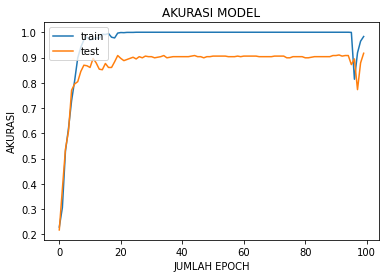

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('AKURASI MODEL')
plt.ylabel('AKURASI')
plt.xlabel('JUMLAH EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

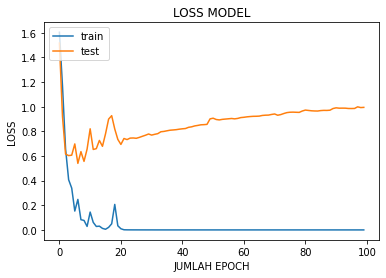

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS MODEL')
plt.ylabel('LOSS')
plt.xlabel('JUMLAH EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()